In [1]:
import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-05-04 06:39:11.121815: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 06:39:11.122053: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 06:39:11.123780: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 06:39:11.152582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 06:39:11.784959: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# # Loading the dataset (using the downloaded file)
# path = "/content/drive/MyDrive/Colab Notebooks/DATA255_Assignment/IMDB_Dataset.csv"
# df = pd.read_csv(path)

In [4]:
df= pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
##cleaning up the text
stopWords = set(nltk.corpus.stopwords.words("english"))
def CleanText(text):
    text = text.lower()
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"]=df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

In [7]:
### converting 1000 most frequent words to integer
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)

tokenizer.fit_on_texts(Data)

IntegerizedData = pd.Series(tokenizer.texts_to_sequences(Data))
IntegerizedData.head()

0    [315, 6873, 3237, 2, 117, 996, 1569, 1033, 117...
1    [342, 2080, 100, 30, 3711, 232, 11, 66, 165, 5...
2    [20, 595, 4986, 24, 8579, 369, 844, 7247, 2536...
3    [8, 5767, 24, 749, 582, 180, 304, 147, 2329, 2...
4    [8836, 1155, 25, 3325, 521, 11, 535, 9224, 920...
dtype: object

In [8]:
### You can convert the sequences back to the string
tokenizer.sequences_to_texts(IntegerizedData[0:1])

['mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky ashton kutcher problem comes kid thinks better anyone else around shows signs closet appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior magic could keep turning hour']

In [9]:
DataLength=IntegerizedData.apply(lambda x: len(x))
DataLength.describe()

count    50000.000000
mean       110.157100
std         81.213625
min          3.000000
25%         60.000000
50%         83.000000
75%        135.000000
max       1104.000000
dtype: float64

The average length of reviews is 110, the shortest review length is 3 and the longest is 1104.

Therefore we need to pad the sequences to equal length.

The following padding function performs zero padding if the length of a sequence is less than the threshold and truncate the ones which are longer than threshold to the threshold.  We choose the threshold to be 256.

In [10]:
#zero padding
IntegerizedData= pad_sequences(IntegerizedData, maxlen=256)


In [11]:
IntegerizedData

array([[   0,    0,    0, ...,  269, 1456,  397],
       [   0,    0,    0, ...,  363,    3,   80],
       [   0,    0,    0, ...,   54,   57,   76],
       ...,
       [   0,    0,    0, ...,  973,   99, 9907],
       [   0,    0,    0, ..., 8508, 3506,   13],
       [   0,    0,    0, ...,   11, 2263,   23]], dtype=int32)

In [12]:
x_train_val,x_test,y_train_val,y_test = train_test_split(IntegerizedData,labels,stratify=labels,test_size=0.20, random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,stratify=y_train_val,test_size=0.10, random_state=42)

In [13]:
type(x_val)

numpy.ndarray

In [14]:
print(y_train.shape,y_val.shape,y_test.shape)

(36000,) (4000,) (10000,)


## now you have your training, validation and test set as numpy arrays, you can implement the networks

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
import time

In [16]:
class LSTMModel_b(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_dim):
        super(LSTMModel_b, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        maxpool_out, _ = torch.max(lstm_out, 1)
        out = self.relu(self.fc1(maxpool_out))
        out = self.sigmoid(self.fc2(out))
        return out

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/80, Time: 0.64s, Train Loss: 0.6929, Val Loss: 0.6924, Train Accuracy: 0.5150, Val Accuracy: 0.5380
Epoch 2/80, Time: 0.41s, Train Loss: 0.6915, Val Loss: 0.6910, Train Accuracy: 0.5688, Val Accuracy: 0.6070
Epoch 3/80, Time: 0.41s, Train Loss: 0.6897, Val Loss: 0.6889, Train Accuracy: 0.6302, Val Accuracy: 0.6082
Epoch 4/80, Time: 0.41s, Train Loss: 0.6870, Val Loss: 0.6856, Train Accuracy: 0.6601, Val Accuracy: 0.6713
Epoch 5/80, Time: 0.40s, Train Loss: 0.6824, Val Loss: 0.6795, Train Accuracy: 0.7123, Val Accuracy: 0.7055
Epoch 6/80, Time: 0.40s, Train Loss: 0.6735, Val Loss: 0.6674, Train Accuracy: 0.7259, Val Accuracy: 0.7145
Epoch 7/80, Time: 0.40s, Train Loss: 0.6507, Val Loss: 0.6237, Train Accuracy: 0.7154, Val Accuracy: 0.6813
Epoch 8/80, Time: 0.61s, Train Loss: 0.5928, Val Loss: 0.5740, Train Accuracy: 0.7118, Val Accuracy: 0.7208
Epoch 9/80, Time: 0.40s, Train Loss: 0.5500, Val Loss: 0.5415, Train Accuracy: 0.7427, Val Accuracy: 0.7372
Epoch 10/80, Time: 0.40s, Tr

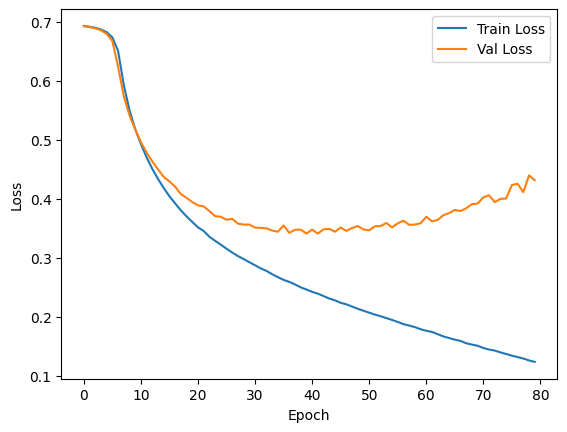

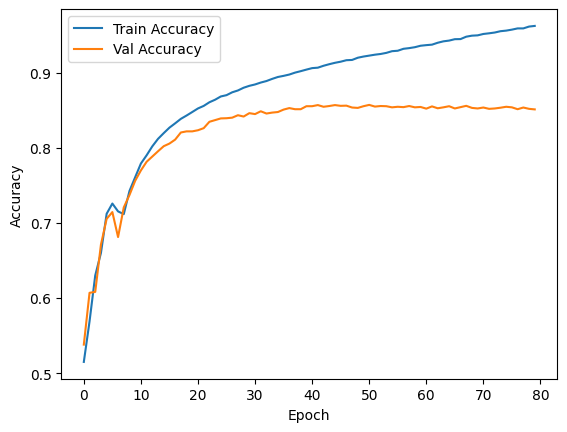

Test Accuracy: 0.8532


In [17]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 1e-3

Epoch 1/80, Time: 0.58s, Train Loss: 0.6942, Val Loss: 0.6920, Train Accuracy: 0.5036, Val Accuracy: 0.5212
Epoch 2/80, Time: 2.98s, Train Loss: 0.6910, Val Loss: 0.6901, Train Accuracy: 0.5703, Val Accuracy: 0.5972
Epoch 3/80, Time: 0.55s, Train Loss: 0.6886, Val Loss: 0.6870, Train Accuracy: 0.6145, Val Accuracy: 0.6362
Epoch 4/80, Time: 2.93s, Train Loss: 0.6847, Val Loss: 0.6824, Train Accuracy: 0.6515, Val Accuracy: 0.6820
Epoch 5/80, Time: 3.27s, Train Loss: 0.6793, Val Loss: 0.6763, Train Accuracy: 0.6767, Val Accuracy: 0.6667
Epoch 6/80, Time: 0.62s, Train Loss: 0.6721, Val Loss: 0.6682, Train Accuracy: 0.7006, Val Accuracy: 0.7107
Epoch 7/80, Time: 3.00s, Train Loss: 0.6627, Val Loss: 0.6574, Train Accuracy: 0.7191, Val Accuracy: 0.7175
Epoch 8/80, Time: 0.81s, Train Loss: 0.6506, Val Loss: 0.6435, Train Accuracy: 0.7271, Val Accuracy: 0.7302
Epoch 9/80, Time: 7.00s, Train Loss: 0.6351, Val Loss: 0.6265, Train Accuracy: 0.7366, Val Accuracy: 0.7380
Epoch 10/80, Time: 3.72s, Tr

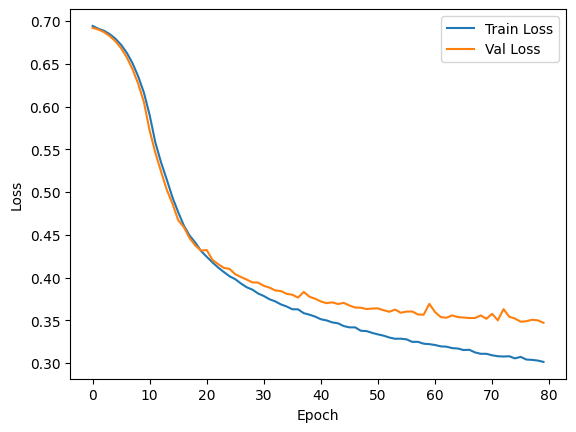

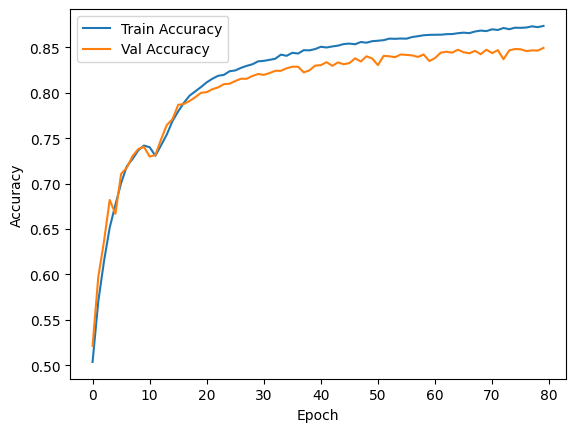

Test Accuracy: 0.8448


In [18]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 1e-3

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 1e-2

Epoch 1/80, Time: 0.83s, Train Loss: 0.6928, Val Loss: 0.6925, Train Accuracy: 0.5136, Val Accuracy: 0.5240
Epoch 2/80, Time: 3.08s, Train Loss: 0.6924, Val Loss: 0.6922, Train Accuracy: 0.5263, Val Accuracy: 0.5475
Epoch 3/80, Time: 3.10s, Train Loss: 0.6921, Val Loss: 0.6919, Train Accuracy: 0.5423, Val Accuracy: 0.5583
Epoch 4/80, Time: 0.59s, Train Loss: 0.6918, Val Loss: 0.6915, Train Accuracy: 0.5587, Val Accuracy: 0.5660
Epoch 5/80, Time: 3.19s, Train Loss: 0.6913, Val Loss: 0.6911, Train Accuracy: 0.5768, Val Accuracy: 0.5840
Epoch 6/80, Time: 0.59s, Train Loss: 0.6908, Val Loss: 0.6904, Train Accuracy: 0.5936, Val Accuracy: 0.6202
Epoch 7/80, Time: 3.19s, Train Loss: 0.6901, Val Loss: 0.6895, Train Accuracy: 0.6366, Val Accuracy: 0.6490
Epoch 8/80, Time: 0.59s, Train Loss: 0.6890, Val Loss: 0.6883, Train Accuracy: 0.6477, Val Accuracy: 0.6670
Epoch 9/80, Time: 3.48s, Train Loss: 0.6875, Val Loss: 0.6866, Train Accuracy: 0.6759, Val Accuracy: 0.6757
Epoch 10/80, Time: 3.15s, Tr

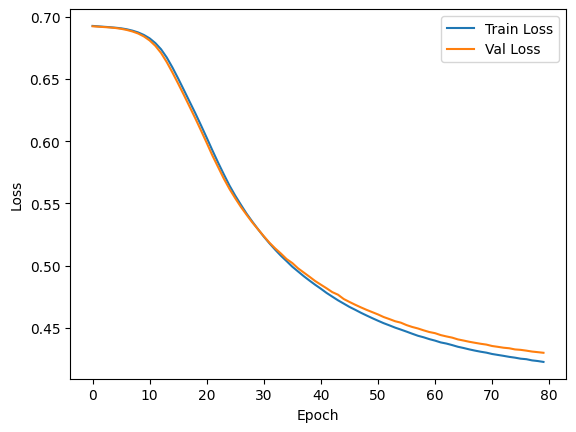

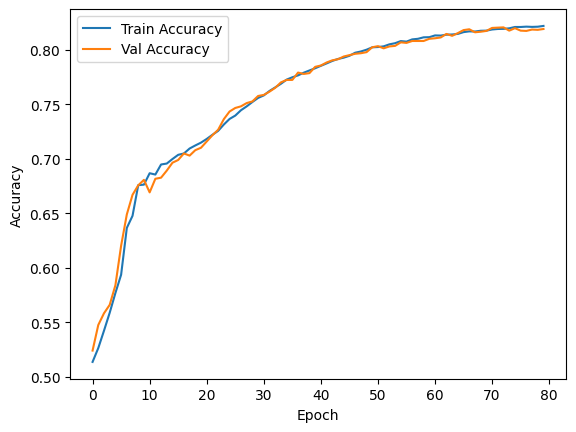

Test Accuracy: 0.8135


In [19]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 1e-2

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 5e-3

Epoch 1/80, Time: 4.88s, Train Loss: 0.6932, Val Loss: 0.6930, Train Accuracy: 0.5014, Val Accuracy: 0.5058
Epoch 2/80, Time: 5.04s, Train Loss: 0.6927, Val Loss: 0.6926, Train Accuracy: 0.5189, Val Accuracy: 0.5218
Epoch 3/80, Time: 0.52s, Train Loss: 0.6923, Val Loss: 0.6921, Train Accuracy: 0.5413, Val Accuracy: 0.5393
Epoch 4/80, Time: 4.86s, Train Loss: 0.6917, Val Loss: 0.6915, Train Accuracy: 0.5567, Val Accuracy: 0.5823
Epoch 5/80, Time: 0.52s, Train Loss: 0.6910, Val Loss: 0.6906, Train Accuracy: 0.5991, Val Accuracy: 0.5843
Epoch 6/80, Time: 4.81s, Train Loss: 0.6899, Val Loss: 0.6892, Train Accuracy: 0.5971, Val Accuracy: 0.5905
Epoch 7/80, Time: 0.51s, Train Loss: 0.6881, Val Loss: 0.6871, Train Accuracy: 0.6081, Val Accuracy: 0.6095
Epoch 8/80, Time: 4.76s, Train Loss: 0.6855, Val Loss: 0.6840, Train Accuracy: 0.6324, Val Accuracy: 0.6238
Epoch 9/80, Time: 0.51s, Train Loss: 0.6819, Val Loss: 0.6798, Train Accuracy: 0.6470, Val Accuracy: 0.6502
Epoch 10/80, Time: 4.86s, Tr

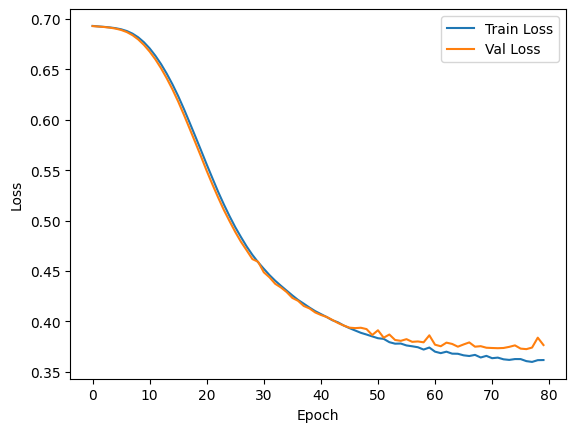

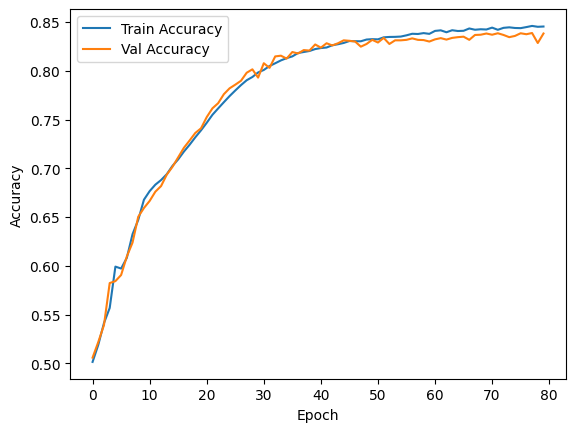

Test Accuracy: 0.8267


In [20]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 5e-3

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 7e-3

Epoch 1/80, Time: 4.77s, Train Loss: 0.6940, Val Loss: 0.6931, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/80, Time: 0.52s, Train Loss: 0.6928, Val Loss: 0.6924, Train Accuracy: 0.5013, Val Accuracy: 0.5012
Epoch 3/80, Time: 4.92s, Train Loss: 0.6924, Val Loss: 0.6921, Train Accuracy: 0.5085, Val Accuracy: 0.5102
Epoch 4/80, Time: 0.51s, Train Loss: 0.6920, Val Loss: 0.6917, Train Accuracy: 0.5294, Val Accuracy: 0.5337
Epoch 5/80, Time: 4.89s, Train Loss: 0.6916, Val Loss: 0.6913, Train Accuracy: 0.5446, Val Accuracy: 0.5587
Epoch 6/80, Time: 0.51s, Train Loss: 0.6912, Val Loss: 0.6907, Train Accuracy: 0.5668, Val Accuracy: 0.5835
Epoch 7/80, Time: 4.91s, Train Loss: 0.6906, Val Loss: 0.6900, Train Accuracy: 0.5926, Val Accuracy: 0.6210
Epoch 8/80, Time: 0.52s, Train Loss: 0.6898, Val Loss: 0.6890, Train Accuracy: 0.6082, Val Accuracy: 0.6402
Epoch 9/80, Time: 4.82s, Train Loss: 0.6885, Val Loss: 0.6875, Train Accuracy: 0.6407, Val Accuracy: 0.6540
Epoch 10/80, Time: 0.51s, Tr

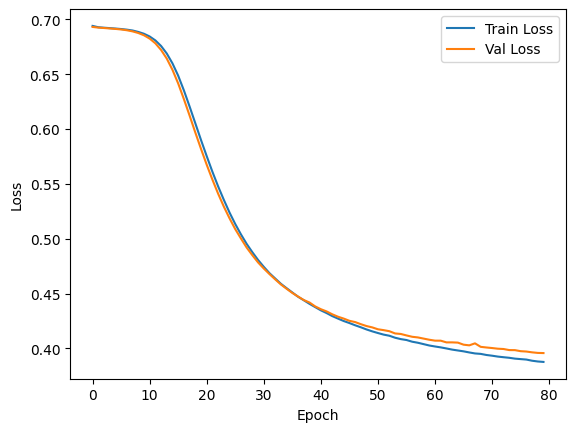

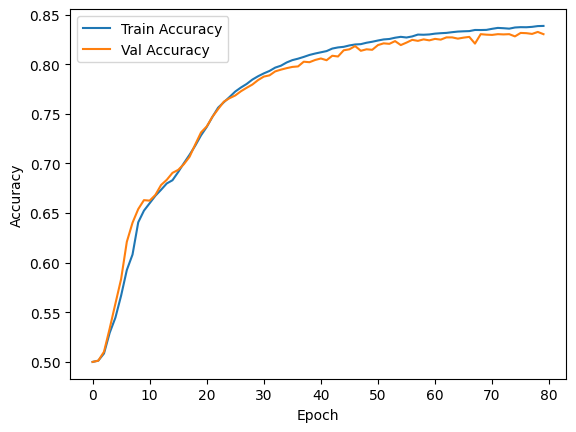

Test Accuracy: 0.8224


In [21]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 7e-3

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 6e-3

Epoch 1/80, Time: 4.70s, Train Loss: 0.6936, Val Loss: 0.6930, Train Accuracy: 0.5002, Val Accuracy: 0.5028
Epoch 2/80, Time: 0.52s, Train Loss: 0.6929, Val Loss: 0.6928, Train Accuracy: 0.5037, Val Accuracy: 0.5205
Epoch 3/80, Time: 4.78s, Train Loss: 0.6927, Val Loss: 0.6926, Train Accuracy: 0.5254, Val Accuracy: 0.5415
Epoch 4/80, Time: 0.50s, Train Loss: 0.6925, Val Loss: 0.6925, Train Accuracy: 0.5292, Val Accuracy: 0.5467
Epoch 5/80, Time: 4.69s, Train Loss: 0.6923, Val Loss: 0.6922, Train Accuracy: 0.5679, Val Accuracy: 0.5733
Epoch 6/80, Time: 0.51s, Train Loss: 0.6920, Val Loss: 0.6918, Train Accuracy: 0.5849, Val Accuracy: 0.5910
Epoch 7/80, Time: 4.81s, Train Loss: 0.6916, Val Loss: 0.6914, Train Accuracy: 0.6004, Val Accuracy: 0.6300
Epoch 8/80, Time: 5.24s, Train Loss: 0.6911, Val Loss: 0.6909, Train Accuracy: 0.6210, Val Accuracy: 0.6360
Epoch 9/80, Time: 0.52s, Train Loss: 0.6904, Val Loss: 0.6900, Train Accuracy: 0.6205, Val Accuracy: 0.6650
Epoch 10/80, Time: 4.87s, Tr

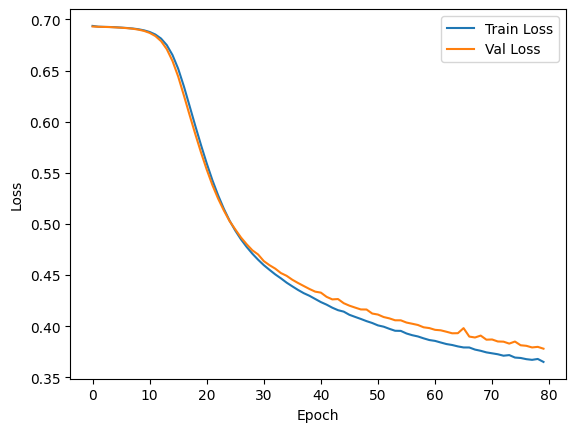

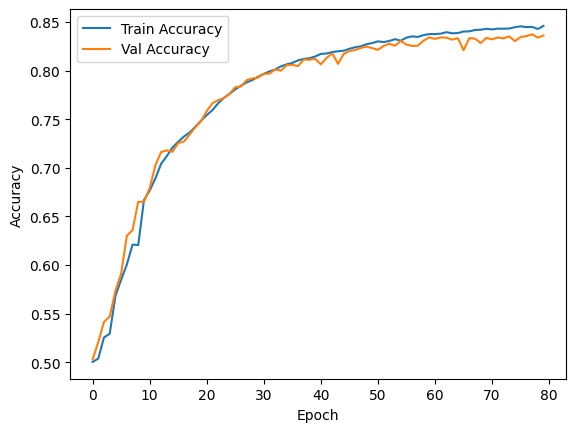

Test Accuracy: 0.8354


In [22]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 6e-3

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 5e-3

Epoch 1/80, Time: 4.89s, Train Loss: 0.6948, Val Loss: 0.6924, Train Accuracy: 0.5004, Val Accuracy: 0.5050
Epoch 2/80, Time: 0.52s, Train Loss: 0.6920, Val Loss: 0.6916, Train Accuracy: 0.5377, Val Accuracy: 0.5627
Epoch 3/80, Time: 4.81s, Train Loss: 0.6911, Val Loss: 0.6907, Train Accuracy: 0.5811, Val Accuracy: 0.6000
Epoch 4/80, Time: 0.51s, Train Loss: 0.6901, Val Loss: 0.6895, Train Accuracy: 0.6094, Val Accuracy: 0.6215
Epoch 5/80, Time: 4.85s, Train Loss: 0.6888, Val Loss: 0.6882, Train Accuracy: 0.6393, Val Accuracy: 0.6535
Epoch 6/80, Time: 0.79s, Train Loss: 0.6873, Val Loss: 0.6864, Train Accuracy: 0.6578, Val Accuracy: 0.6615
Epoch 7/80, Time: 4.78s, Train Loss: 0.6853, Val Loss: 0.6841, Train Accuracy: 0.6695, Val Accuracy: 0.6675
Epoch 8/80, Time: 0.52s, Train Loss: 0.6826, Val Loss: 0.6811, Train Accuracy: 0.6753, Val Accuracy: 0.6655
Epoch 9/80, Time: 4.81s, Train Loss: 0.6791, Val Loss: 0.6769, Train Accuracy: 0.6742, Val Accuracy: 0.6685
Epoch 10/80, Time: 0.53s, Tr

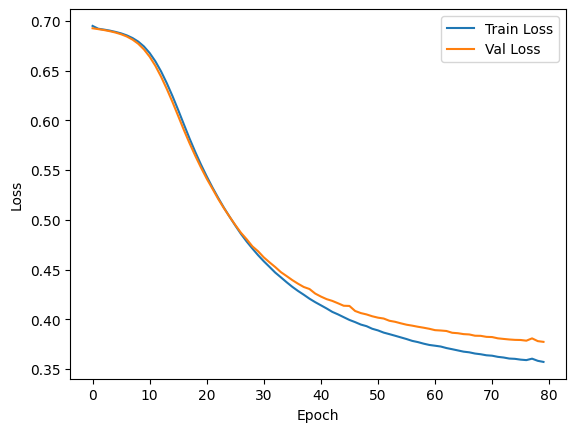

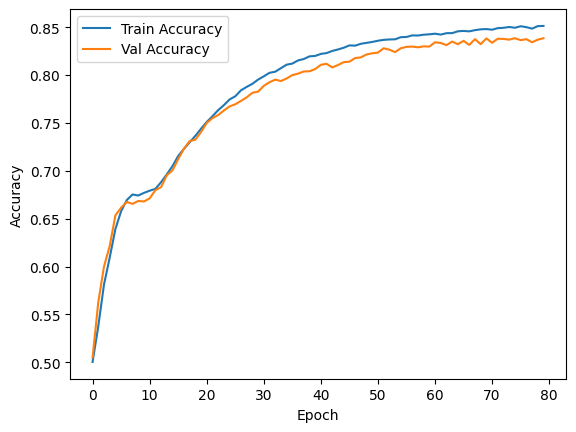

Test Accuracy: 0.8332


In [23]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 5e-3

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 4e-3

Epoch 1/80, Time: 4.82s, Train Loss: 0.6984, Val Loss: 0.6941, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/80, Time: 0.52s, Train Loss: 0.6928, Val Loss: 0.6920, Train Accuracy: 0.5009, Val Accuracy: 0.5018
Epoch 3/80, Time: 4.92s, Train Loss: 0.6914, Val Loss: 0.6911, Train Accuracy: 0.5165, Val Accuracy: 0.5473
Epoch 4/80, Time: 0.54s, Train Loss: 0.6905, Val Loss: 0.6903, Train Accuracy: 0.5710, Val Accuracy: 0.5765
Epoch 5/80, Time: 4.75s, Train Loss: 0.6896, Val Loss: 0.6893, Train Accuracy: 0.6036, Val Accuracy: 0.6065
Epoch 6/80, Time: 0.52s, Train Loss: 0.6885, Val Loss: 0.6880, Train Accuracy: 0.6303, Val Accuracy: 0.6342
Epoch 7/80, Time: 4.73s, Train Loss: 0.6868, Val Loss: 0.6859, Train Accuracy: 0.6492, Val Accuracy: 0.6603
Epoch 8/80, Time: 0.53s, Train Loss: 0.6839, Val Loss: 0.6822, Train Accuracy: 0.6741, Val Accuracy: 0.6885
Epoch 9/80, Time: 4.82s, Train Loss: 0.6795, Val Loss: 0.6768, Train Accuracy: 0.6999, Val Accuracy: 0.7053
Epoch 10/80, Time: 0.54s, Tr

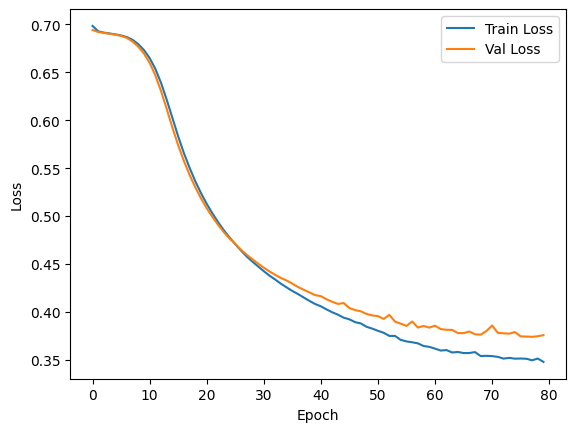

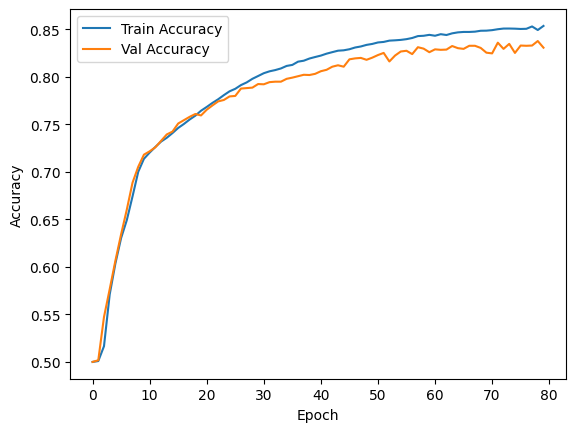

Test Accuracy: 0.8292


In [24]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 4e-3

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 3.8e-3

Epoch 1/80, Time: 0.52s, Train Loss: 0.6951, Val Loss: 0.6930, Train Accuracy: 0.4999, Val Accuracy: 0.5000
Epoch 2/80, Time: 4.92s, Train Loss: 0.6926, Val Loss: 0.6923, Train Accuracy: 0.5090, Val Accuracy: 0.5315
Epoch 3/80, Time: 0.79s, Train Loss: 0.6920, Val Loss: 0.6917, Train Accuracy: 0.5306, Val Accuracy: 0.5547
Epoch 4/80, Time: 4.75s, Train Loss: 0.6915, Val Loss: 0.6911, Train Accuracy: 0.5475, Val Accuracy: 0.5783
Epoch 5/80, Time: 0.52s, Train Loss: 0.6908, Val Loss: 0.6904, Train Accuracy: 0.5742, Val Accuracy: 0.5857
Epoch 6/80, Time: 4.87s, Train Loss: 0.6899, Val Loss: 0.6893, Train Accuracy: 0.6040, Val Accuracy: 0.6048
Epoch 7/80, Time: 0.53s, Train Loss: 0.6884, Val Loss: 0.6874, Train Accuracy: 0.6215, Val Accuracy: 0.6498
Epoch 8/80, Time: 4.83s, Train Loss: 0.6861, Val Loss: 0.6846, Train Accuracy: 0.6628, Val Accuracy: 0.6583
Epoch 9/80, Time: 0.51s, Train Loss: 0.6825, Val Loss: 0.6801, Train Accuracy: 0.6832, Val Accuracy: 0.6845
Epoch 10/80, Time: 4.83s, Tr

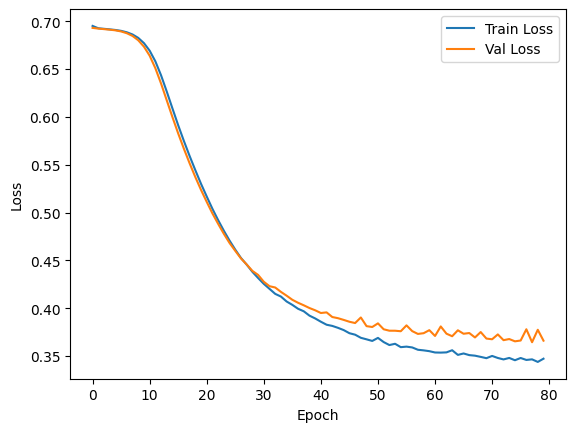

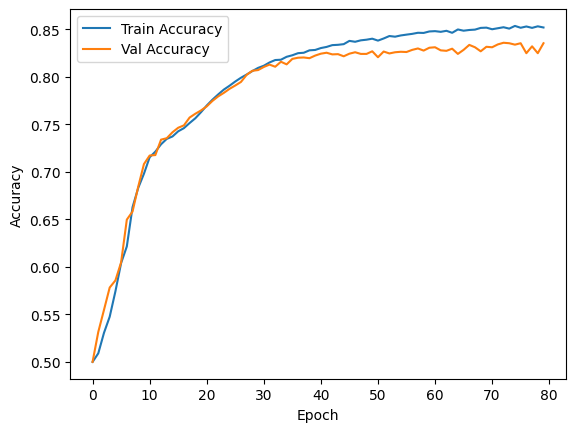

Test Accuracy: 0.8344


In [25]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80
weight_decay = 3.8e-3

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 3.7e-3
# Best Graph
## Hyperparameters
## L2 Regularization = 3.7e-3
## Batch Size = 512
## Learning Rate = 0.0001

Epoch 1/100, Time: 4.75s, Train Loss: 0.6948, Val Loss: 0.6929, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/100, Time: 0.52s, Train Loss: 0.6923, Val Loss: 0.6917, Train Accuracy: 0.5032, Val Accuracy: 0.5120
Epoch 3/100, Time: 4.92s, Train Loss: 0.6911, Val Loss: 0.6907, Train Accuracy: 0.5373, Val Accuracy: 0.5700
Epoch 4/100, Time: 0.53s, Train Loss: 0.6899, Val Loss: 0.6893, Train Accuracy: 0.5975, Val Accuracy: 0.6145
Epoch 5/100, Time: 4.85s, Train Loss: 0.6883, Val Loss: 0.6873, Train Accuracy: 0.6267, Val Accuracy: 0.6312
Epoch 6/100, Time: 0.52s, Train Loss: 0.6859, Val Loss: 0.6846, Train Accuracy: 0.6472, Val Accuracy: 0.6465
Epoch 7/100, Time: 4.90s, Train Loss: 0.6826, Val Loss: 0.6809, Train Accuracy: 0.6624, Val Accuracy: 0.6690
Epoch 8/100, Time: 4.90s, Train Loss: 0.6781, Val Loss: 0.6753, Train Accuracy: 0.6833, Val Accuracy: 0.6900
Epoch 9/100, Time: 0.52s, Train Loss: 0.6712, Val Loss: 0.6671, Train Accuracy: 0.6986, Val Accuracy: 0.6993
Epoch 10/100, Time:

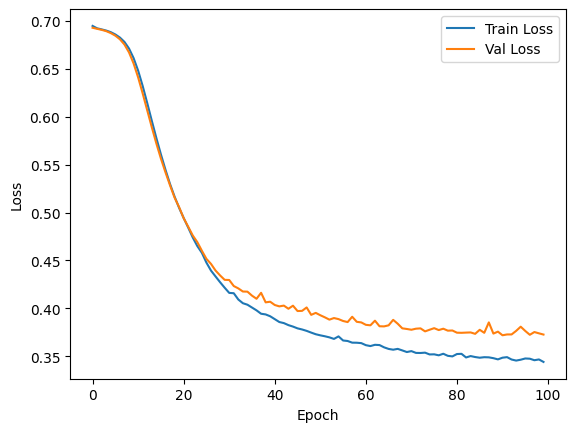

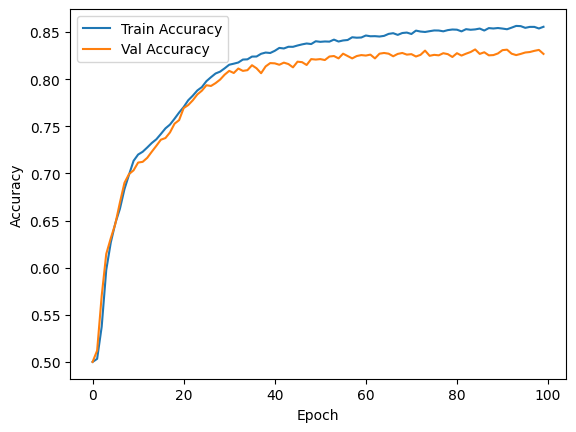

Test Accuracy: 0.8334


In [26]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1)).float().to(device)  # Reshape labels
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 100
weight_decay = 3.7e-3

# Instantiate the model and move it to GPU if available
model = LSTMModel_b(embedding_dim, frequentWord, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop (unchanged)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses (unchanged)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies (unchanged)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set (unchanged)
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')

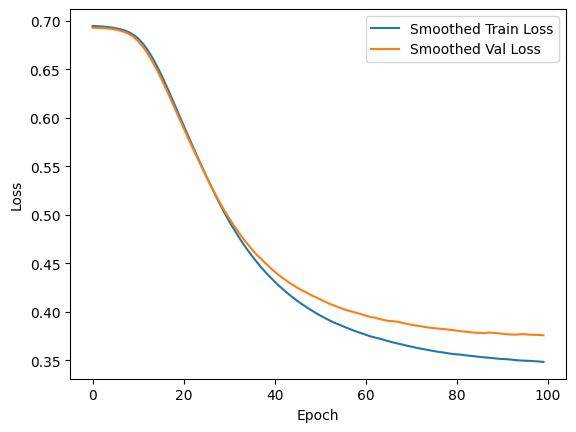

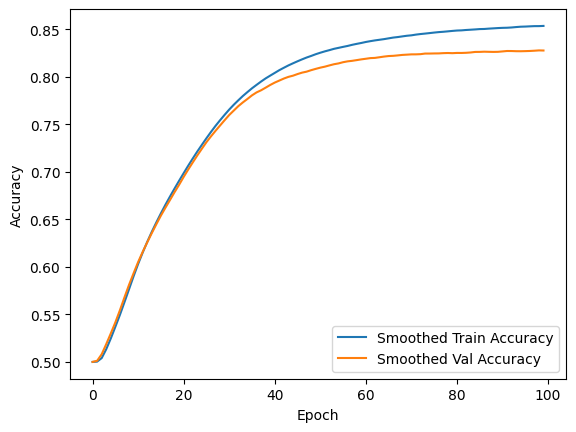

Test Accuracy: 0.8334


In [27]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy (unchanged)
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))  # Reshape labels
print(f'Test Accuracy: {test_accuracy:.4f}')